# Linear Models For Target Pregnancy Prediction Problems

This notebook presents basic from-scratcj implementations of linear and logistic regression, and applies the models to the Target data set presented in *Data Smart: Using Data Science to Transform Information into Insight Smart* by John W. Foreman (Wiley, 2020, chapter 6). The data sets contains features on customer behaviour and labels each observation as pregnant (PREGNANT = 1) or not pregnant (PREGNANT = 0). The observations are balanced, with 500 positives and 500 negatives.

In the following we will presents the two classes implementing linear and logistic regression, quickly analize the data set (it is already cleaned) and train the models. Finally we will compare the perfomarmances.

There is a second notebook in the same folder that uses that same data set with ensemble methods (bagging and boosting).

### Summary
1. Import Necesessary Modules
2. Define The `LinReg` Class Implementing Linear Regression
3. Define  `LogReg` Class Implementing Logistic Regression
4. Use Case: Predicting Pregnancy On The Target Data Set
    * 4.1. Univariate Analysis
    * 4.2. Feature Manipulaton
    * 4.3. Linear Probability Model (LPM)
    * 4.4. Simple Logistic Regression
    * 4.5. Logistic Regression With Hyper-parameter Optimization
5. Conclusions

## 1. Import Necesessary Modules

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Define The `LinReg` Class Implementing Linear Regression

The class has two methods: `fit` and `predict`. `fit` accepts the disign matrix $X$ whose columns (that have to include the intercept) represent the regressor and a target variable vector $y$. Everything is supposed to be a Pandas dataframe. `predict` only takes in the predictor matrix and returns the predicted values as a Pandas series.

 - Once a `LinReg` object is fitted attributes like betas, standard errors, p-values and so on are available.

 - Coefficients are estimated via OLS closed form: $\hat{\beta} = (X^T X)^{-1} X^T y$
 
 - Standard errors are heteroscedasticity-consistent (Huber-White): $s.e. = (X^T X)^{-1} (X^T diag(\hat{u}_1^2,...,\hat{u}_n^2) X) (X^T X)^{-1}$, where $\hat{u_i}$ denotes the residual relative to the $i-$th observation.



In [2]:
class LinReg():
    """
    Implements OLS for multiple regression. 
    ======
    
    The `fit` method expects :
        
    * A numpy array of regressors X with observations on the rows and covariats on the columns.
    
    * Intercept must be included in the first column as a series of 1s.
    """
    def __init__(self):
        self.X = None
        self.beta = None
        self.cov = None
        self.se = None
        self.t = None
        self.p = None
        self.dof = None
        self.R2 = None
        self.R2_adj = None
        self.F = None
    
    def fit(self, X, y):
        """
        Fits OLS estimator. Uses White standard errors.
        """
        assert len(X) == len(y)
        design_inv = np.linalg.inv(np.dot(X.T, X)) 
        
        self.beta = np.dot(np.dot(design_inv, X.T), y)    
        self.dof = X.shape[0] - X.shape[1]           
            
        self.TSS_ = np.sum((y - np.mean(y)) ** 2)
        
        u2 = (self.predict(X) - y) ** 2      
        self.RSS_ = np.sum(u2)
        self.R2 = 1 - self.RSS_ / self.TSS_
        self.R2_adj = 1 - (1 - self.R2) * (X.shape[0]-1) / self.dof
        self.F = (self.TSS_ / self.RSS_ - 1) / (X.shape[0] - 1) * self.dof
        
        self.cov = np.dot(design_inv, np.dot(np.dot(X.T, np.dot(np.diag(u2), X)), design_inv))
        self.se = np.sqrt(np.diag(self.cov))
        self.t = self.beta / self.se
        self.p = 2 * stats.t.cdf(-np.abs(self.t), df=self.dof)
        
    def predict(self, X):
        """
        Predicts y based on X
        """
        return np.dot(X, self.beta)

## 3. Define  `LogReg` Class Implementing Logistic Regression

The class has two public methods: `fit` and `predict`. `fit` accepts the disign matrix $X$ whose columns (that have to include the intercept) represent the regressor and a target variable vector $y$. Everything is supposed to be a Pandas dataframe. `predict` only takes in the predictor matrix and returns the predicted values as a Pandas series. If the argument `probs` is set to `False` the score is returned, otherwise (by default) probabilities are returned.

- `fit` estimates coeffients via gradient descent with optional Ridge regularization: 
    - The parameter `alpha` is the Ridge parameter (default is 0, *i.e.*, no regularization)
    - The parameter `gamma` is the learning rate for gradient descent


The static methods, `logL_` and `grad_logL_` compute the log-likelihood and its gradient. They are meant as helper functions, but are also available to the user if necessary.

In [3]:
class LogReg():
    """
    Implements Logistic regression. 
    ======
    
    The `fit` method expects :
        
    * A numpy array of regressors X with observations on the rows and covariats on the columns.
    
    * Intercept must be included in the first column as a series of 1s.
    """
    def __init__(self):
        self.X = None
        self.beta = None
        self.logL = None

    
    @staticmethod
    def logL_(X, y, b, alpha=0):
        """
        Static method computing the log-likelihood
        """
        assert alpha >= 0
        p = 1 / (1 + np.exp(-np.dot(X, b)))
        return (np.sum(y * np.log(p)) + np.sum((1-y) * np.log(1-p)) - 0.5 * alpha * np.dot(b, b)) / X.shape[0]

    @staticmethod
    def grad_logL_(X, y, b, alpha=0):
        """
        Static method computing the gradient of the log-likelihood
        """
        assert alpha >= 0
        p = 1 / (1 + np.exp(-np.dot(X, b)))
        return (np.dot(X.T, y - p) - alpha * b) / X.shape[0]
    
    def fit(self, X, y, alpha=0, gamma=0.01, max_iter=10000, tol=0.001):
        """
        Fits logistic regression by maximizing the log-likelihood.
        If alpha > 0 uses L^2 regularization (i.e. Ridge regression)
        with learning rate gamma.
        """
        assert len(X) == len(y)
        
        # initialize coeffs as OLS estimate
        self.beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        for i in range(max_iter):
            grad = LogReg.grad_logL_(X, y, self.beta, alpha)
            if np.linalg.norm(grad) < tol:
                break
            else:
                self.beta += gamma * grad
        self.logL = LogReg.logL_(X, y, self.beta, alpha)
        

        
    def predict(self, X, probs=True):
        """
        Predicts y based on X. if probs=True returns proabilities, otherwise 
        returns the score.
        """
        if probs:
            return 1 / (1 + np.exp(-np.dot(X, self.beta)))
        else:
            return np.dot(X, self.beta)

## 4. Use Case: Predicting Pregnancy On The Target Data Set

In [2]:
# load data set
preg = pd.read_excel('RetailMart.xlsx')
preg.drop('Unnamed: 17', inplace=True, axis=1) # remove null column
preg.head()

,Implied Gender,Home/Apt/ PO Box,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Stopped buying ciggies,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes,PREGNANT
0,M,A,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,M,H,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,M,H,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,U,H,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,F,A,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1


### 4.1. Univariate Analysis

Feature names are mostly self-explanatory. Below some details:

- **Implied Gender**: M (male), F (female) or U (unknown)
- **Wine** and **Cigarettes** mean 'recently bought' wine/cigarettes
- **Home/Apt/PO** assumes three values: H = account holder address is home, A = aprtment, P = PO box

All features are binary or discrete variables, so univariate analysis is quite easy: we can plot the *pregnancy rate* for each value of each feature.

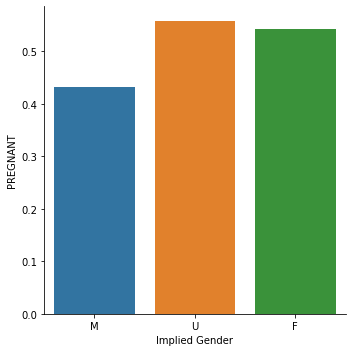

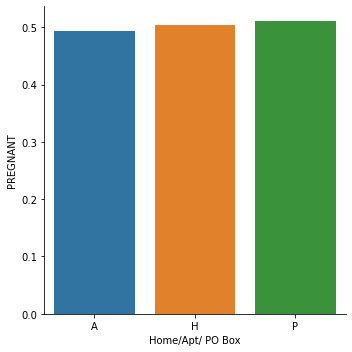

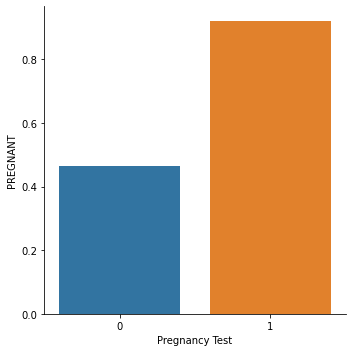

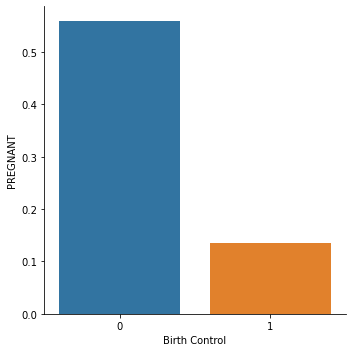

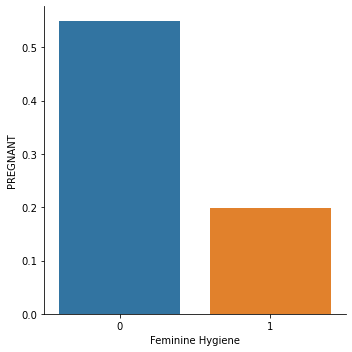

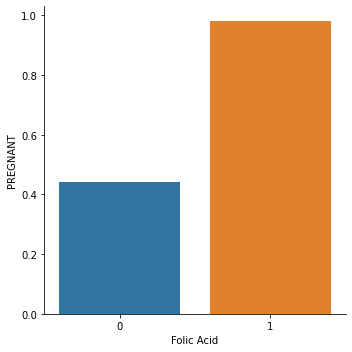

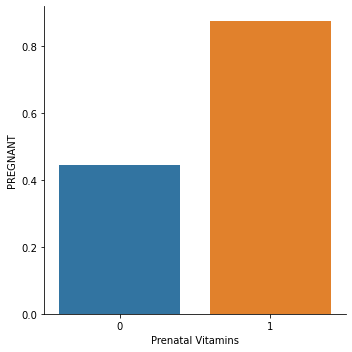

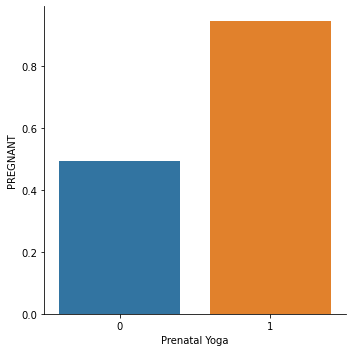

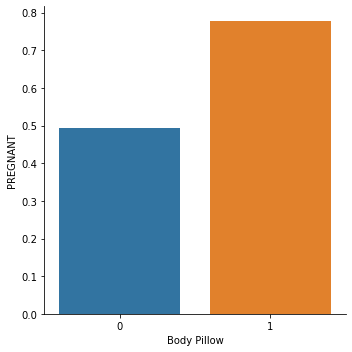

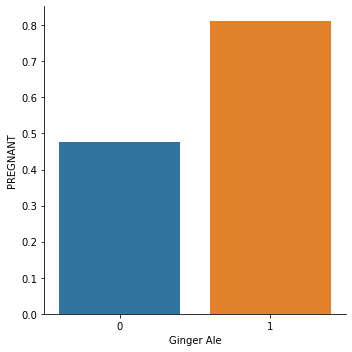

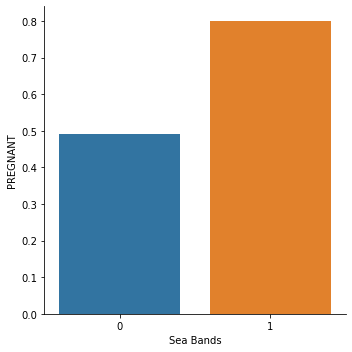

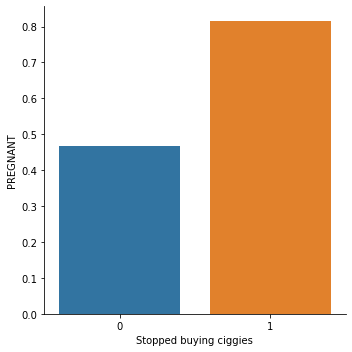

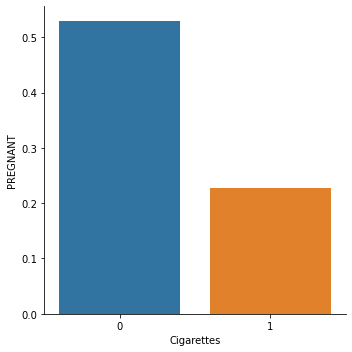

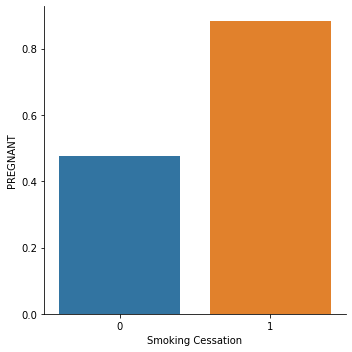

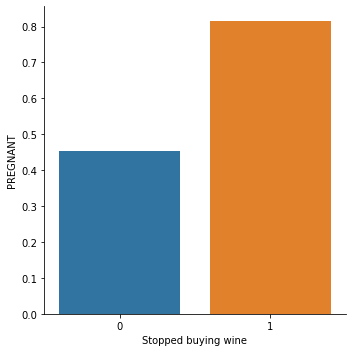

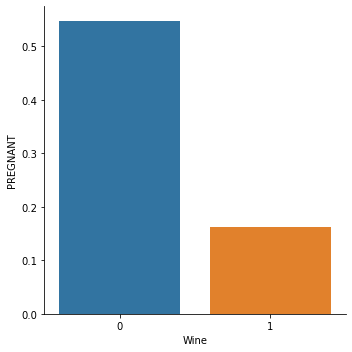

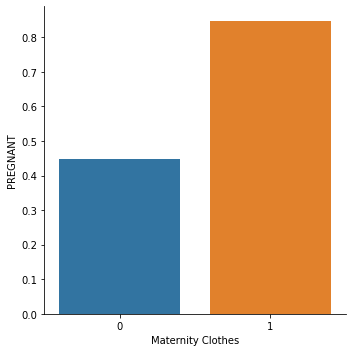

In [6]:
features = list(preg.columns)
features.remove('PREGNANT')

for feature in features:
    sns.catplot(data=preg, kind='bar', x = feature, y='PREGNANT', ci=None)

### 4.2. Feature Manipulaton

From univariate analysis, almost all of the variables look predictive except **Home/Apt/ PO Box** variable which we will drop. Also **Implied Gender** seems to imply only that males are less likely to be pregnant, so we will create a dummy variable for 'Implied Gender = M'.

In [7]:
preg['Male'] = (preg['Implied Gender'] == 'M').astype(int)
preg.drop(['Implied Gender', 'Home/Apt/ PO Box'], axis=1, inplace=True)

In [8]:
X = preg.drop('PREGNANT', axis=1)
X.insert(loc=0, column='Intercept', value=1)
y = preg['PREGNANT']

### 4.3. Linear Probability Model (LPM)

We start with the simplest model, the so called Linear probability model. It hase the form:

$$\mathbb{E}[y_i] = \mathbf{x}_i^T \mathbf{\beta}$$

It is essentially a linea regression of the pregnancy probability on the features. The only drawback is that it can predict probabilities outside of the $[0, 1]$ range.

We start by splitting the data set in training and test samples.

In [10]:
# split train and test datasets
dim_train = 330
dim_test = 170 # c.a. 2/3 train, 1/3 test for each value of PREGNANT

X_train0 = X[y==0].sample(n=dim_train)
X_test0 = X[y==0].drop(X_train0.index, axis=0)

X_train1 = X[y==1].sample(n=dim_train)
X_test1 = X[y==1].drop(X_train1.index, axis=0)

X_train = X_train0.append(X_train1)
X_test = X_test0.append(X_test1)
y_train= y[X_train.index]
y_test = y[X_test.index]

In [11]:
# fit linear regression
lpm = LinReg()
lpm.fit(X_train,y_train)
p_hat = lpm.predict(X_test)

We can look at a summary of our regression: all features are significant and the signs are as expected (e.g. **Pregnancy Test**'s beta is positive while **Birth Control**'s is negative).

In [39]:
# Regression results
summary = pd.DataFrame({'Variable': X_train.columns, 'Coeff.': lpm.beta, 'Std. error:': lpm.se, 'P-value': lpm.p})
summary.head(X_train.shape[1])

,Variable,Coeff.,Std. error:,P-value
0,Intercept,0.425097,0.030170,1.733006e-39
1,Pregnancy Test,0.270530,0.047160,1.489361e-08
2,Birth Control,-0.290500,0.032799,7.973047e-18
3,Feminine Hygiene,-0.279509,0.032814,1.150109e-16
4,Folic Acid,0.321675,0.035604,1.901592e-18
5,Prenatal Vitamins,0.299039,0.036131,7.328808e-16
6,Prenatal Yoga,0.415687,0.076904,9.128684e-08
7,Body Pillow,0.207572,0.064674,1.395718e-03
8,Ginger Ale,0.232179,0.053944,1.938187e-05
9,Sea Bands,0.157262,0.087452,7.260227e-02


Another way to assess the model is to check how many predictions fall out of range:

In [23]:
out_of_range_pct = np.sum((p_hat > 1) | (p_hat < 0)) / len(p_hat) # % out of boundary
print('Percentage of predicted probs. out of range = {:.2f}%'.format(out_of_range_pct * 100))

Percentage of predicted probs. out of range = 15.00%


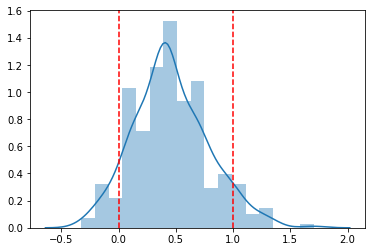

In [41]:
fig = sns.distplot(p_hat)
fig.axvline(x=0, color='red', linestyle='--')
fig.axvline(x=1, color='red', linestyle='--')

Finally, we can compute the *Accuracy* (i.e. the percentage of correctly classifed instances) and the AUC (Area Under The Curve).

In [45]:
y_hat = (p_hat > 0.5).astype(int)
Accuracy = np.mean(y_hat == y_test) # Accuracy
print('Accuracy(% correctly classified) = {:.2f}%'.format(Accuracy * 100))

Accuracy(% correctly classified) = 85.88%


In [37]:
# helper function to compute AUC and draw ROC curve
def auc(score, y_test, lower=-3, upper=3, bins=100, print_curve=False):
    s = np.linspace(lower, upper, bins)
    xx = []
    yy = []

    for cutoff in s:
        y_hat = (score > cutoff).astype(int)
        xx.append(sum(y_hat[y_test==0]==1) / sum(y_test==0))
        yy.append(sum(y_hat[y_test==1]==1) / sum(y_test==1))
    area=0
    for i in range(1, len(xx)):
        area += 0.5 * np.abs(xx[i] - xx[i-1]) * (yy[i-1] + yy[i])

    if print_curve:
        plt.plot(xx,yy)
        plt.fill_between(xx,yy, alpha=0.05)
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel("FPR (1 - specificity)")
        plt.ylabel("TPR (sensitivity)")
        plt.text(0.5,0.5,'AUC = {:.2f}%'.format(area*100), fontsize=16)
    else:
        return area

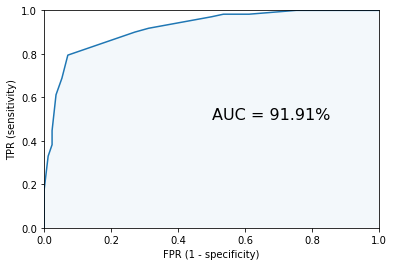

In [38]:
auc(p_hat, y_test, print_curve=True)

### 4.4. Simple Logistic Regression

A more appropriate way to model probabilities is the logistic model, a Generalized Linear Model (GLM) of the form:

$$\mathbb{E}[y_i] = g(\mathbf{x}_i^T \mathbf{\beta})$$

where $g$ is the well-known sigmoid function, i.e. $g(z) = 1/(1+ e^{-z})$:

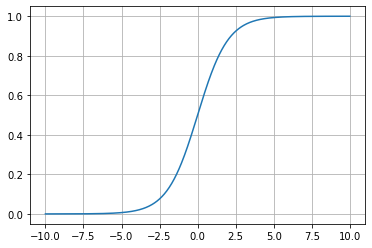

In [3]:
z = np.linspace(-10,10, 500)
g = 1/(1 + np.exp(-z))
plt.plot(z,g)
plt.grid(10)

It can be fitting via maximum-likelihood, the log-likelihood being:

$$ \mathcal{L} = \log L = \frac{1}{n} \sum_{i=1}^n \left[ y_i \log g(\mathbf{x}_i \mathbf{\beta}) + (1-y_i) \log (1 - g(\mathbf{x}_i \mathbf{\beta})) \right]$$ 

In [41]:
lreg = LogReg()
lreg.fit(X_train, y_train)
p_hat = lreg.predict(X_test)

In [44]:
y_hat = (p_hat > 0.5).astype(int)
Accuracy = np.mean(y_hat == y_test) # Accuracy
print('Accuracy(% correctly classified) = {:.2f}%'.format(Accuracy * 100))

Accuracy(% correctly classified) = 85.88%


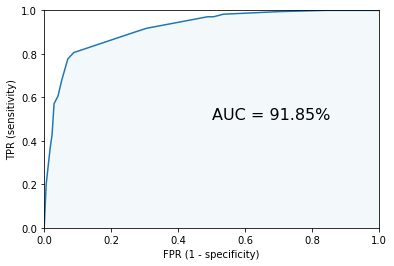

In [43]:
auc(p_hat, y_test, print_curve=True)

Actually not a great improvement on the LPM.

### 4.5. Logistic Regression With Hyper-parameter Optimization


We can add a touch of sophistication using a regularizing factor the loglikelihodd:

$$ \mathcal{L}_{reg} = \mathcal{L} + \frac{1}{2} \alpha \lVert \mathbf{\beta} \rVert ^2$$

Also, we can try to find the best hyper-parameters $\alpha$ and $\gamma$ (learning rate of the gradient descent). We will use a basic grid-search. In this case we need to split the sample in three subsamples:

- Training data set (50%)
- Test data set (25%), which we use to fine-tune the hyper-parameters
- Validation data set (25%), which we use to actually test the out-of-sample performance of the model

In [46]:
dim_train = 250
dim_test = 125
dim_valid = 125 # 50% train, 25% test, 25% validation

X_train0 = X[y==0].sample(n=dim_train)
X_test0 = X[y==0].drop(X_train0.index, axis=0).sample(n=dim_test)
X_valid0 = X[y==0].drop(X_train0.index, axis=0).drop(X_test0.index, axis=0)

X_train1 = X[y==1].sample(n=dim_train)
X_test1 = X[y==1].drop(X_train1.index, axis=0).sample(n=dim_test)
X_valid1 = X[y==1].drop(X_train1.index, axis=0).drop(X_test1.index, axis=0)


X_train = X_train0.append(X_train1)
X_test = X_test0.append(X_test1)
X_valid = X_valid0.append(X_valid1)
y_train= y[X_train.index]
y_test = y[X_test.index]
y_valid = y[X_valid.index]

In [65]:
# hyper-parameter optimization via grid-search
alpha = np.linspace(0,1,11)
gamma = np.linspace(0.005, 0.2, 11)
grid_search = np.zeros([len(alpha), len(gamma)])
for i in range(len(alpha)):
    for j in range(len(gamma)):
        lreg.fit(X_train, y_train, alpha=alpha[i], gamma=gamma[j])
        grid_search[i][j] = auc(lreg.predict(X_test), y_test)

In [66]:
arg_max = np.unravel_index(grid_search.argmax(), grid_search.shape)
print(f'argmax = {arg_max}')

argmax = (0, 5)


In [67]:
lreg.fit(X_train, y_train, alpha=alpha[2], gamma=gamma[0])
p_hat = lreg.predict(X_valid)

In [68]:
y_hat = (p_hat > 0.5).astype(int)
Accuracy = np.mean(y_hat == y_test) # Accuracy
print('Accuracy(% correctly classified) = {:.2f}%'.format(Accuracy * 100))

Accuracy(% correctly classified) = 86.40%


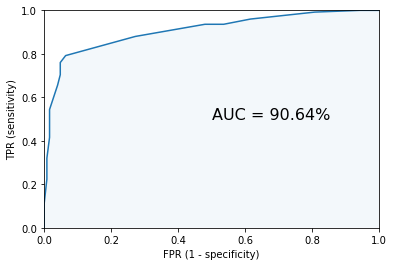

In [69]:
auc(p_hat, y_valid, print_curve=True)

## 5. Conclusions

 - LPM works fine, simple logistic does not add much in terms of performance
 - Not much gained in regularization with hyper-parmeter fine-tuning either
 - One important caveat: this is a very simple (and more importantly simulated) data set, so the data is pretty good. In reality, with noisier data, we would expect logistic regression to work better than LPM and with really scarce data Ridge logistic to outperform simple logistic.